In [ ]:
# Tien Thanh Nguyen

# CONTENT



1. Overview
2. Data Preparation
3. Data Processing
4. Analytics
 - 4.1. The correlation between bikes IN/OUT a day (using Linear Regression)
 - 4.2. The number of bikes in use per day
 - 4.3. The average number of bikes in use by weekday
 - 4.4. The usage percentage
 - 4.5. Analyse 116 Stations: using Seaborn, K-means, Support Vector Machines

# 1. OVERVIEW

##1.1. What is the Dublin Bikes dataset?

**Dublin Bikes** is a bike-sharing scheme in operation from bicycle docks and stations in Dublin City. The datasets of Dublin Bikes can be downloaded from https://data.gov.ie/dataset/dublinbikes-api

This link also provides an API to get data at any time. However, in the scope of this study, the next segments focus on 10 .CSV resources that have been extracted from the Dublin Bikes database from Q3 2018 to Q4 2020.

These datasets save the historic operation of 116 Bike Stations in Dublin with **a 5-minute interval**. It means that every 5 minutes, a new row will be recorded in the database to demonstrate the current operation of a Bike Station at this time including some fields such as station id, time, bikes available, bike stands available, etc.

These records were extracted from the database to 10 .csv files relevant to 10 quarters from Q3 2018 to Q4 2020. The total volume of these 10 .csv files is 2.99 GB and the total rows are approximately 26.7 million.


##1.2. Data dictionary

Field Name | Field Type | Field Description
--- | --- | ---
STATION ID | numeric | Globally unique identifier of station.
TIME |	timestamp	| Time of fetching the data.
LAST UPDATED | timestamp	| Time of last updated information.
NAME | text | Station name.
BIKE STANDS |	numeric | Station total number of bike stands.
AVAILABLE BIKE | STANDS	numeric	| Station available bike stands.
AVAILABLE BIKES |	numeric	| Station available bikes.
STATUS |	text | Station status (Open/Close).
ADDRESS	| text	| Station address.
LATITUDE |	numeric	| Station latitude.
LONGITUDE |	numeric	| Station longitude.

#2. DATA PREPARATION (combine data from multiple CSV files, filter/clean data)

You can use an **ETL tool** such as Google Cloud Dataflow, Pentaho, Talend Open Studio, etc. for data preparation.

For example, below is the data preparation processed by **Talend Open Studio**, including 4 steps:
*   Create 10 metadata(s) corresponding to the 10 above-mentioned CSV files.
*   Create a Talend Job, use a *tUnite* component to combine the data of the 10 metadata(s).
*   Next, use a *tMap* component to filter data; split TIME into DATE/HOUR/MINUTE; remove unimportant columns such as LAST UPDATED, STATUS.
*   Finally, use a *tFileOutputDelimited* component to save the output data into a new CSV file.



---


###**The final CSV files for analytics are:**
* **dublinbikes_combined_data.csv** (the historic operation data from Q3-2018 to Q4-2020)
 - Size: 741.6 MB
 - Length: **~26.7 million rows**
 - Columns: STATION_ID,	BIKE_STANDS,	AVAILABLE_BIKE_STANDS,	AVAILABLE_BIKES, DATE,	HOUR,	MINUTE 
* **dublinbikes_stations.csv** (list of 116 stations)
 - Size: 7 KB
 - Length: **116 rows**
 - Columns: STATION_ID,	NAME,	ADDRESS,	LATITUDE,	LONGITUDE,	BIKE_STANDS  

**All files are archived in a zip file (dublinbikes_Q3_2018_Q4_2020.zip) which is the input data for this Python Notebook.**

You can download this zip file on the link: https://drive.google.com/file/d/1BYp-xskw8d0wC6fsNlvZz65bOdDItawL/view?usp=sharing


# 3. DATA PROCESSING

##3.1. Uploading the input data to Google Colab, read data and assign to a DataFrame for coding

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np

In [ ]:
# Link download file: https://drive.google.com/file/d/1BYp-xskw8d0wC6fsNlvZz65bOdDItawL/view?usp=sharing

from google.colab import files
uploaded = files.upload()

!unzip /content/dublinbikes_Q3_2018_Q4_2020.zip

# Beside two CSVs has been mentioned above (dublinbikes_combined_data.csv and dublinbikes_stations.csv),
# you can see the third CSV file: dublinbikes_daily_in_out.csv
# In the next section (3.2.2), it will be clarified

Saving dublinbikes_Q3_2018_Q4_2020.zip to dublinbikes_Q3_2018_Q4_2020.zip
Archive:  /content/dublinbikes_Q3_2018_Q4_2020.zip
  inflating: dublinbikes_combined_data.csv  
  inflating: __MACOSX/._dublinbikes_combined_data.csv  
  inflating: dublinbikes_daily_in_out.csv  
  inflating: __MACOSX/._dublinbikes_daily_in_out.csv  
  inflating: dublinbikes_stations.csv  
  inflating: __MACOSX/._dublinbikes_stations.csv  


In [ ]:
# Load list of stations
stations_df = pd.read_csv('dublinbikes_stations.csv')
stations_df

,STATION_ID,NAME,ADDRESS,LATITUDE,LONGITUDE,BIKE_STANDS
0,1,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,31
1,2,BLESSINGTON STREET,Blessington Street,53.356770,-6.268140,20
2,3,BOLTON STREET,Bolton Street,53.351180,-6.269859,20
3,4,GREEK STREET,Greek Street,53.346874,-6.272976,20
4,5,CHARLEMONT PLACE,Charlemont Street,53.330660,-6.260177,40
...,...,...,...,...,...,...
111,113,MERRION SQUARE SOUTH,Merrion Square South,53.338615,-6.248606,40
112,114,WILTON TERRACE (PARK),Wilton Terrace (Park),53.333652,-6.248345,40
113,115,KILLARNEY STREET,Killarney Street,53.354843,-6.247579,30
114,116,BROADSTONE,Broadstone,53.354700,-6.272314,30


In [ ]:
# Load the historic operation data from Q3-2018 to Q4-2020
df = pd.read_csv('dublinbikes_combined_data.csv')

# Remove duplicated rows
#   + Before: ~26.7 million rows
#   + After: ~26.5 million rows
#   + It has duplicated rows because in the original CSV files, the end date of the 1st file is also the start date of the 2nd file and so on
#   + e.i.
#     + Q3 2018: dublinbikes_20180701_20181001.csv
#     + Q4 2018: dublinbikes_20181001_20190101.csv
#     + Duplicated rows in 2018-10-01
df.drop_duplicates(inplace=True)

# Convert the column "DATE" from string to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

df.describe()

,STATION_ID,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,HOUR,MINUTE
count,2.655697e+07,2.655697e+07,2.655697e+07,2.655697e+07,2.655697e+07,2.655697e+07
mean,5.933679e+01,3.209601e+01,2.050313e+01,1.135692e+01,1.148872e+01,2.750023e+01
std,3.330804e+01,7.600869e+00,1.150320e+01,1.024440e+01,6.914114e+00,1.726121e+01
min,1.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e+01,2.900000e+01,1.200000e+01,2.000000e+00,6.000000e+00,1.000000e+01
50%,5.900000e+01,3.000000e+01,2.000000e+01,9.000000e+00,1.100000e+01,3.000000e+01
75%,8.800000e+01,4.000000e+01,3.000000e+01,1.800000e+01,1.700000e+01,4.500000e+01
max,1.170000e+02,4.000000e+01,5.600000e+01,4.300000e+01,2.300000e+01,5.500000e+01


##3.2. Caculate the level of traffic on an daily basis (Bikes IN & Bikes OUT per day of a specific STATION)

BIKE_STANDS is always equal to AVAILABLE_BIKE_STANDS plus AVAILABLE_BIKES at any time *(Station total number of bike stands = Station available bike stands + Station available bikes)*.

So, the increase of AVAILABLE_BIKES is equal to the decrease of AVAILABLE_BIKE_STANDS and vice versa.

**Moreover, as the data has been sorted by time, we can use only the columns AVAILABLE_BIKES to calculate the Bikes IN and Bikes OUT per day** (based on an increase or decrease of the "Station available bike stands" in comparison with the previous record)



###3.2.1. Function to convert the historic operation to the level of traffic per day

Function name: **parse_Bikes_Int_Out**
* *Parameter*: A DataFrame with a column AVAILABLE_BIKES (input_df is the historic operation of a BIKE STATION in a specific DAY with a 5-minute interval. input_df has approximately 24*60/5 = 288 rows) 
* *Output*: The function will return a List with two values:
 - 1st value is the Bikes IN of this day
 - 2nd value is the Bikes OUT of this day
* *Algorithms*:
 - All rows in Dublin Bikes CSV files have been saved in chronological order. So, the DataFrame parameter does too.
 - Loop all rows of the DataFrame: compare the AVAILABLE_BIKES value of the current row with the AVAILABLE_BIKES value of the previous row. The difference value will be added to Bikes IN if this value is positive. Otherwise, add to Bikes OUT.

* However, for better performance, we can transform DataFame instead of using Loop:
 - input_df['AVAILABLE_BIKES'] has n rows from k0 to k(n-1) 
 - create new columns input_df['NEXT_AVAILABLE_BIKES'] has n-1 rows from k1 to k(n-2) and the last row is equal to input_df['AVAILABLE_BIKES'][last_row]
 - input_df['IN_OUT'] = input_df['NEXT_AVAILABLE_BIKES'] - input_df['AVAILABLE_BIKES'].
 - SUM positive values for Bikes IN
 - SUM negative values for Bikes OUT

In [ ]:
def parse_Bikes_Int_Out(input_df):
  s = input_df['AVAILABLE_BIKES'].copy()
  a = s.pop(0)
  s2 = pd.Series([s[len(s)]])
  s = s.append(s2)
  s = s.reset_index(drop=True)
  input_df['NEXT_AVAILABLE_BIKES'] = s
  input_df['IN_OUT'] = input_df['NEXT_AVAILABLE_BIKES'] - input_df['AVAILABLE_BIKES']
  _in = input_df[input_df['IN_OUT'] > 0]['IN_OUT'].sum()
  _out = -input_df[input_df['IN_OUT'] < 0]['IN_OUT'].sum()
  return [_in, _out]

###3.2.2. The level of traffic per day of all STATIONS

In [ ]:
# Initial bikes_in_out
bikes_in_out = df[['STATION_ID','DATE']].copy()
bikes_in_out.drop_duplicates(inplace=True)
bikes_in_out.reset_index(inplace=True)
bikes_in_out.drop(axis=1, columns='index', inplace=True)
bikes_in_out['BIKES_IN'] = 0
bikes_in_out['BIKES_OUT'] = 0
bikes_in_out

# You can see that the start date is 2018-08-01 and the end date is 2021-01-01
# Suprised?
# I don't know why but in the orginal .csv file of Q3-2018, the dataset starts from 2018-08-01.
# And in the .csv file of Q4-2020, the end date is 2021-01-01.

,STATION_ID,DATE,BIKES_IN,BIKES_OUT
0,1,2018-08-01,0,0
1,2,2018-08-01,0,0
2,3,2018-08-01,0,0
3,4,2018-08-01,0,0
4,5,2018-08-01,0,0
...,...,...,...,...
93744,113,2021-01-01,0,0
93745,114,2021-01-01,0,0
93746,115,2021-01-01,0,0
93747,116,2021-01-01,0,0


In [ ]:
# Slicing data from df for calculating the level of traffic per day of all STATIONS
sub_df = df[['STATION_ID','DATE','AVAILABLE_BIKES']]

In [ ]:
# ===================================================
# NOTES: THE DATA IS QUITE BIG
# WE NEED TO SLICE 93749 TIMES (length of bikes_in_out) FROM A DATAFRAME "SUB_DF" WITH ~ 26.7 MILLIONS ROWS, 
# THEN TRANSFORM TMP_DATA TO CALCULATE THE BIKES IN, BIKES OUT
# IT TAKES ~ 1.5 HOURS.
# THEREFORE I RECOMMEND YOU NOT TO RUN THIS CELL
# YOU SHOULD RUN THE NEXT CELL (GET DATA FROM dublinbikes_daily_in_out.csv)
# dublinbikes_daily_in_out.csv IS THE DATA OF THE DATAFRAME bikes_in_out THAT HAS BEEN DONE AFTER RUNNING BELOW LOOP ON MY COMPUTER
# ===================================================

range_ = bikes_in_out.index.tolist()
# from 0 to 93748

# Loop all 93749 rows for calculating the level of traffic per day of all STATIONS 
for i in range_:
  stationId = bikes_in_out.at[i,'STATION_ID']
  date = bikes_in_out.at[i,'DATE']

  # The historic operation of a specific station in a particular day
  tmp_data = sub_df[(sub_df['STATION_ID'] == stationId) & (sub_df['DATE'] == date)][['AVAILABLE_BIKES']].reset_index()

  if (tmp_data.empty):
    bikes_in_out.at[i,'BIKES_IN'] = 0
    bikes_in_out.at[i,'BIKES_OUT'] = 0
  else:
    tmp_data.drop(columns='index', axis=1, inplace=True)
    # Call the parse_Bikes_Int_Out function to caculate the level of traffic per day
    output = parse_Bikes_Int_Out(tmp_data)
    bikes_in_out.at[i,'BIKES_IN'] = output[0]
    bikes_in_out.at[i,'BIKES_OUT'] = output[1]

In [ ]:
bikes_in_out = pd.read_csv('dublinbikes_daily_in_out.csv')
bikes_in_out['DATE'] = pd.to_datetime(bikes_in_out['DATE'], format='%d/%m/%Y')

bikes_in_out

,STATION_ID,DATE,BIKES_IN,BIKES_OUT
0,1,2018-08-01,56,73
1,2,2018-08-01,33,18
2,3,2018-08-01,31,28
3,4,2018-08-01,19,27
4,5,2018-08-01,93,78
...,...,...,...,...
93744,113,2021-01-01,1,1
93745,114,2021-01-01,5,10
93746,115,2021-01-01,10,20
93747,116,2021-01-01,5,9


# 4. ANALYTICS

##4.1. The correlation between Bikes IN and Bikes OUT per day

Linear Regression techniques is used to show a roughly linear relationship between Bikes IN and Bikes OUT

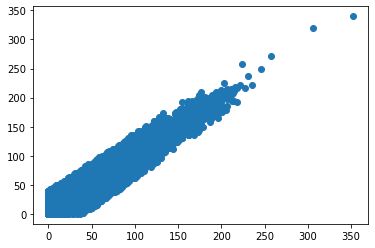

In [ ]:
from pylab import *

scatter(bikes_in_out['BIKES_IN'], bikes_in_out['BIKES_OUT'])

In [ ]:
from scipy import stats
from numpy import float

slope, intercept, r_value, p_value, std_err = stats.linregress(bikes_in_out['BIKES_IN'].astype(float), bikes_in_out['BIKES_OUT'].astype(float))
# Show the linear equation
print('Linear Equation: Y = ' + str("{:.5f}".format(slope)) + 'X + ' + str("{:.5f}".format(intercept)))

print(r_value ** 2)

Linear Equation: Y = 0.97130X + 1.34486
0.9342132440873561


Next, use the slope and intercept that we got from the regression **to plot predicted values vs. observed**

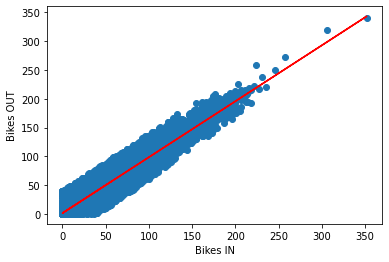

In [ ]:
def predict(x):
  return slope * x + intercept

fitLine = predict(bikes_in_out['BIKES_IN'])
plt.scatter(bikes_in_out['BIKES_IN'], bikes_in_out['BIKES_OUT'])
plt.plot(bikes_in_out['BIKES_IN'], fitLine, c='r')
plt.xlabel('Bikes IN')
plt.ylabel('Bikes OUT')
plt.show()

**Evaluation:**

According to the chart, the Bikes IN and Bikes OUT per day are quite closely related. There is no significant difference between Bikes IN and Bike OUT. **Therefore, it can be assumed that most people take their bikes back for the day instead of leaving them overnight**

## 4.2. The number of bikes in use per day

### 4.2.1. From Q3-2018 to Q4-2020

In [ ]:
# Data for plot
daily_bike_usage = bikes_in_out[['DATE','BIKES_OUT']].groupby(by='DATE').sum('BIKE_OUT').reset_index()

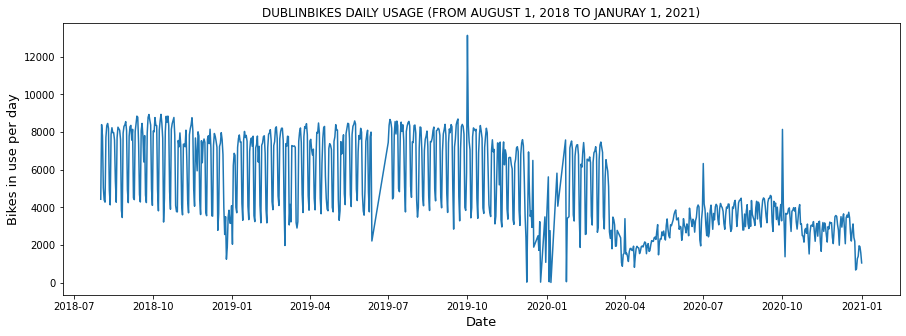

In [ ]:
# Plot the number of bikes in use per day
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(daily_bike_usage['DATE'], daily_bike_usage['BIKES_OUT'])
plt.title('DUBLINBIKES DAILY USAGE (FROM AUGUST 1, 2018 TO JANURAY 1, 2021)')
plt.xlabel('Date', size=13)
plt.ylabel('Bikes in use per day', size=13)
plt.show()

###4.2.2. Compare 2019 with 2020

In [ ]:
# The number of bikes in use per day in 2019
begin_2019 = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_2019 = pd.to_datetime('2019-12-31', format='%Y-%m-%d')
daily_bike_usage_2019 = daily_bike_usage[(daily_bike_usage['DATE'] >= begin_2019) & (daily_bike_usage['DATE'] <= end_2019)].reset_index()

# The number of bikes in use per day in 2020
begin_2020 = pd.to_datetime('2020-01-01', format='%Y-%m-%d')
end_2020 = pd.to_datetime('2020-12-31', format='%Y-%m-%d')
daily_bike_usage_2020 = daily_bike_usage[(daily_bike_usage['DATE'] >= begin_2020) & (daily_bike_usage['DATE'] <= end_2020)].reset_index()

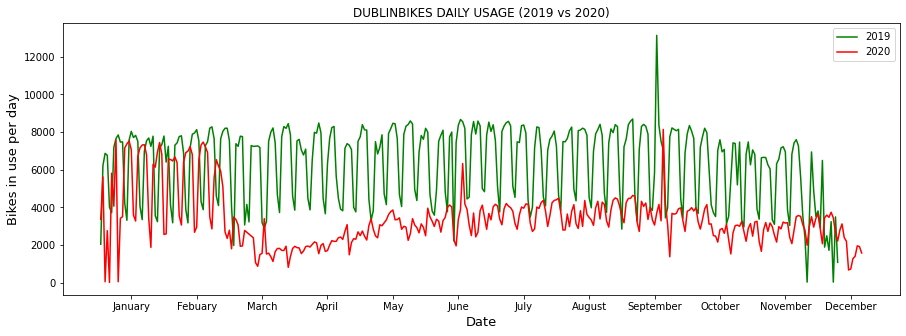

In [ ]:
# Plot the data
plt.figure(figsize=(15,5))
plt.plot(daily_bike_usage_2019['DATE'].index, daily_bike_usage_2019['BIKES_OUT'], c='green', label='2019')
plt.plot(daily_bike_usage_2020['DATE'].index, daily_bike_usage_2020['BIKES_OUT'], c='red', label='2020')
plt.title('DUBLINBIKES DAILY USAGE (2019 vs 2020)')
plt.xlabel('Date', size=13)
plt.ylabel('Bikes in use per day', size=13)

# Set x label (12 months)
x = [14]
for i in range(0,11):
  x.append(x[i]+30)
plt.xticks(x, ['January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

plt.legend()
plt.show()

**Evaluation:**

According to the graphs, it can be assumed that due to the Covid-19 pandemic, the level of traffic in 2020 was down nearly 50% compared with a year ago

## 4.3. The average number of bikes in use by weekday

In [ ]:
daily_bike_usage['WEEKDAY'] = daily_bike_usage['DATE'].apply(lambda x: x.isocalendar()[2])
bikes_weekday = daily_bike_usage[['WEEKDAY', 'BIKES_OUT']].groupby(by='WEEKDAY').mean().reset_index()

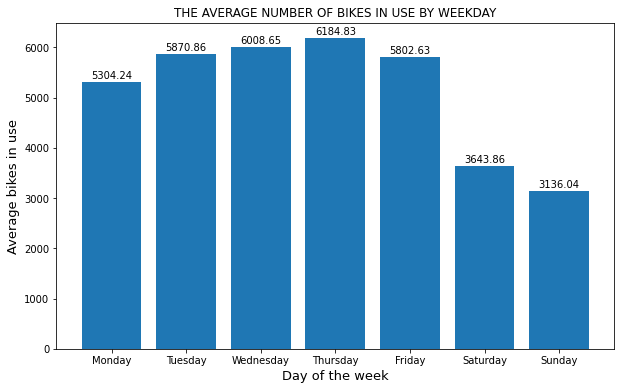

In [ ]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10,6))
# Set title & axis labels
ax.set_title('THE AVERAGE NUMBER OF BIKES IN USE BY WEEKDAY')
plt.xlabel('Day of the week', size=13)
plt.ylabel('Average bikes in use', size=13)

# Plot a bar 
plt.bar(['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], bikes_weekday['BIKES_OUT'])

# Show value for all bars
rects = ax.patches
for rect, value in zip(rects, bikes_weekday['BIKES_OUT']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 30, "{:.2f}".format(value), ha='center', va='bottom')

**Evaluation:**

The number of people using DublinBikes on weekdays is more than that on weekends

## 4.4. The usage percentage: =(total bikes - available bikes) / total bikes
Notes: The total of bikes in DublinBikes is 1600 (from March 2018)

### 4.4.1. In Daily

In [ ]:
# Average available bikes per station per day
available_bikes_by_station_and_day = df[['STATION_ID','DATE','AVAILABLE_BIKES']].groupby(['STATION_ID','DATE']).mean('AVAILABLE_BIKES').reset_index()

In [ ]:
# Average available bikes per day (SUM of all stations in a day)
available_bikes_by_day = available_bikes_by_station_and_day[['DATE','AVAILABLE_BIKES']].groupby(['DATE']).sum('AVAILABLE_BIKES').reset_index()
available_bikes_by_day.rename(columns={'AVAILABLE_BIKES':'AVG_AVAILABLE_BIKES'}, inplace=True)
available_bikes_by_day

,DATE,AVG_AVAILABLE_BIKES
0,2018-08-01,1224.028986
1,2018-08-02,1220.427083
2,2018-08-03,1247.024306
3,2018-08-04,1292.138889
4,2018-08-05,1291.447917
...,...,...
838,2020-12-28,1345.003472
839,2020-12-29,1334.454861
840,2020-12-30,1331.680556
841,2020-12-31,1350.079861


In [ ]:
# The total of bikes in DublinBikes is 1600 (from March 2018)
available_bikes_by_day['TOTAL_DUBLIN_BIKES'] = 1600
# percentage =(total bikes - available bikes) / total bikes)
available_bikes_by_day['USAGE_PERCENTAGE'] = (available_bikes_by_day['TOTAL_DUBLIN_BIKES'] - available_bikes_by_day['AVG_AVAILABLE_BIKES']) \
                                                  / available_bikes_by_day['TOTAL_DUBLIN_BIKES'] * 100

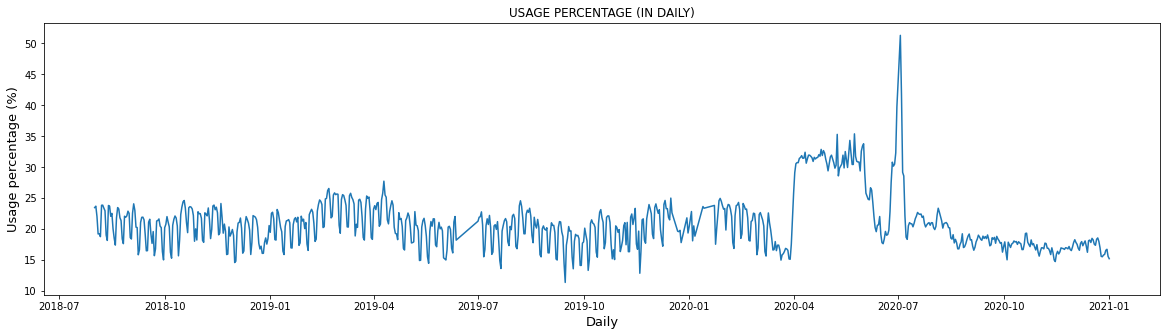

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(daily_bike_usage['DATE'], available_bikes_by_day['USAGE_PERCENTAGE'])
plt.title('USAGE PERCENTAGE (IN DAILY)')
plt.xlabel('Daily', size=13)
plt.ylabel('Usage percentage (%)', size=13)
plt.show()

### 4.4.2. In Hourly (calculated by 5-min intervals)

In [ ]:
# Average available bikes per station per 5-min interval
available_bikes_by_station_and_5min_interval = df[['STATION_ID','HOUR','MINUTE','AVAILABLE_BIKES']].groupby(['STATION_ID','HOUR','MINUTE']).mean().reset_index()

In [ ]:
# Average available bikes per 5-min interval (SUM of all stations in a 5-min intetval)
available_bikes_by_5min_interval = available_bikes_by_station_and_5min_interval[['HOUR', 'MINUTE', 'AVAILABLE_BIKES']].groupby(['HOUR', 'MINUTE']).sum().reset_index()
available_bikes_by_5min_interval.rename(columns={'AVAILABLE_BIKES':'AVG_AVAILABLE_BIKES'}, inplace=True)
# The total of bikes in DublinBikes is 1600 (from March 2018)
available_bikes_by_5min_interval['TOTAL_DUBLIN_BIKES'] = 1600
# percentage =(total bikes - available bikes) / total bikes)
available_bikes_by_5min_interval['USAGE_PERCENTAGE'] = (available_bikes_by_5min_interval['TOTAL_DUBLIN_BIKES'] - available_bikes_by_5min_interval['AVG_AVAILABLE_BIKES']) \
                                                  / available_bikes_by_5min_interval['TOTAL_DUBLIN_BIKES'] * 100

available_bikes_by_5min_interval

,HOUR,MINUTE,AVG_AVAILABLE_BIKES,TOTAL_DUBLIN_BIKES,USAGE_PERCENTAGE
0,0,0,1366.111072,1600,14.618058
1,0,5,1366.232002,1600,14.610500
2,0,10,1366.493628,1600,14.594148
3,0,15,1366.802411,1600,14.574849
4,0,20,1367.159781,1600,14.552514
...,...,...,...,...,...
283,23,35,1357.605803,1600,15.149637
284,23,40,1361.272792,1600,14.920451
285,23,45,1363.487969,1600,14.782002
286,23,50,1364.528293,1600,14.716982


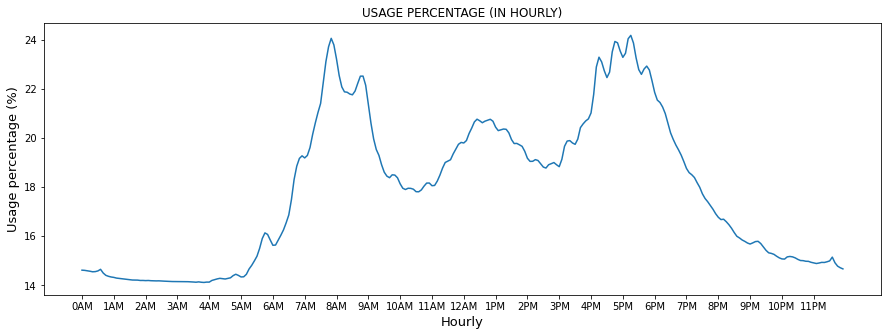

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(available_bikes_by_5min_interval.index, available_bikes_by_5min_interval['USAGE_PERCENTAGE'])
plt.title('USAGE PERCENTAGE (IN HOURLY)')
plt.xlabel('Hourly', size=13)
plt.ylabel('Usage percentage (%)', size=13)

x = [0]
for i in range(0,23):
  x.append(x[i]+12)
plt.xticks(x, ['0AM','1AM','2AM','3AM','4AM','5AM','6AM','7AM','8AM','9AM','10AM','11AM', \
               '12AM','1PM','2PM','3PM','4PM','5PM','6PM','7PM','8PM','9PM','10PM','11PM'])
plt.show()

### 4.4.3. Peak times (usage percentage >= 80%)

In [ ]:
# Available bikes per 5-min interval (SUM of all stations in a 5-min interval)
peak_5min_intervals = df[['DATE','HOUR','MINUTE','AVAILABLE_BIKES']].groupby(['DATE','HOUR','MINUTE']).sum().reset_index()
peak_5min_intervals.rename(columns={'AVAILABLE_BIKES':'AVG_AVAILABLE_BIKES'}, inplace=True)
# The total of bikes in DublinBikes is 1600 (from March 2018)
peak_5min_intervals['TOTAL_DUBLIN_BIKES'] = 1600
# percentage =(total bikes - available bikes) / total bikes)
peak_5min_intervals['USAGE_PERCENTAGE'] = (peak_5min_intervals['TOTAL_DUBLIN_BIKES'] - peak_5min_intervals['AVG_AVAILABLE_BIKES']) \
                                                  / peak_5min_intervals['TOTAL_DUBLIN_BIKES'] * 100

peak_5min_intervals.describe()

,HOUR,MINUTE,AVG_AVAILABLE_BIKES,TOTAL_DUBLIN_BIKES,USAGE_PERCENTAGE
count,238822.000000,238822.000000,238822.000000,238822.0,238822.000000
mean,11.487355,27.500377,1262.887477,1600.0,21.069533
std,6.914376,17.261261,103.022096,0.0,6.438881
min,0.000000,0.000000,50.000000,1600.0,7.187500
25%,5.000000,10.000000,1215.000000,1600.0,16.312500
50%,11.000000,30.000000,1289.000000,1600.0,19.437500
75%,17.000000,45.000000,1339.000000,1600.0,24.062500
max,23.000000,55.000000,1485.000000,1600.0,96.875000


In [ ]:
number_of_peaktime = len(peak_5min_intervals[peak_5min_intervals['USAGE_PERCENTAGE'] >= 80].index)
rate = number_of_peaktime / len(peak_5min_intervals.index) * 100
print("The rate of peak times is ",rate,'%. Very very very low!')

The rate of peak times is  0.00460594082622204 %. Very very very low!


**Evaluation:**
According to the 2 above graphs and the rate of "peak times", in my opinion, the usage percentage of DublinBikes at below a "Medium" level. In the near future, we don't need to buy more bikes. We should analyze each station to redistribute the bike at each station for more efficiency.

## 4.5. Analyse 116 Stations

### 4.5.1. Station features and show their correlation by using seaborn library

In [ ]:
# The average daily traffic of each station
avg_traffic_by_station = bikes_in_out[['STATION_ID', 'BIKES_IN', 'BIKES_OUT']].groupby(by='STATION_ID').mean().reset_index()
avg_traffic_by_station.rename(columns={'BIKES_IN': 'AVG_DAILY_BIKES_IN', 'BIKES_OUT': 'AVG_DAILY_BIKES_OUT'}, inplace=True)

# The number of times that there are NO any available BIKE in a specific station
zero_bikes_by_station = df[df['AVAILABLE_BIKES'] == 0][['STATION_ID', 'DATE']].groupby(['STATION_ID']).count().reset_index()
zero_bikes_by_station.rename(columns={'DATE':'NO._ROWS_WITH_ZERO_BIKES'}, inplace=True)

# The number of times that there are NO any available BIKE STAND in a specific station
zero_bike_stands_by_station = df[df['AVAILABLE_BIKE_STANDS'] == 0][['STATION_ID', 'DATE']].groupby(['STATION_ID']).count().reset_index()
zero_bike_stands_by_station.rename(columns={'DATE':'NO._ROWS_WITH_ZERO_BIKE_STANDS'}, inplace=True)

# The total of 5-min interval records of each station
total_rows_by_station = df[['STATION_ID','DATE']].groupby(['STATION_ID']).count().reset_index()
total_rows_by_station.rename(columns={'DATE':'TOTAL_ROWS'}, inplace=True)

# The average available bikes of each station
avg_available_bikes_by_station = df[['STATION_ID', 'AVAILABLE_BIKES']].groupby('STATION_ID').mean().reset_index()
avg_available_bikes_by_station.rename(columns={'AVAILABLE_BIKES': 'AVG_AVAILABLE_BIKES'}, inplace=True)

# The average available bike stands of each station
avg_available_bike_stands_by_station = df[['STATION_ID', 'AVAILABLE_BIKE_STANDS']].groupby('STATION_ID').mean().reset_index()
avg_available_bike_stands_by_station.rename(columns={'AVAILABLE_BIKE_STANDS': 'AVG_AVAILABLE_BIKE_STANDS'}, inplace=True)

In [ ]:
station_features_df = stations_df.copy()

# Merge all above dataframes into station_features_df
station_features_df = station_features_df.merge(avg_available_bikes_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')

station_features_df = station_features_df.merge(avg_available_bike_stands_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')

station_features_df = station_features_df.merge(avg_traffic_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')

station_features_df = station_features_df.merge(total_rows_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')

station_features_df = station_features_df.merge(zero_bikes_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')
# The rate of zero bikes
station_features_df['ZERO_BIKES_PERCENTAGE'] = station_features_df['NO._ROWS_WITH_ZERO_BIKES']/station_features_df['TOTAL_ROWS']

station_features_df = station_features_df.merge(zero_bike_stands_by_station, left_on='STATION_ID', right_on='STATION_ID', how='inner')
# The rate of zero bike stands
station_features_df['ZERO_BIKE_STANDS_PERCENTAGE'] = station_features_df['NO._ROWS_WITH_ZERO_BIKE_STANDS']/station_features_df['TOTAL_ROWS']

station_features_df

,STATION_ID,NAME,ADDRESS,LATITUDE,LONGITUDE,BIKE_STANDS,AVG_AVAILABLE_BIKES,AVG_AVAILABLE_BIKE_STANDS,AVG_DAILY_BIKES_IN,AVG_DAILY_BIKES_OUT,TOTAL_ROWS,NO._ROWS_WITH_ZERO_BIKES,ZERO_BIKES_PERCENTAGE,NO._ROWS_WITH_ZERO_BIKE_STANDS,ZERO_BIKE_STANDS_PERCENTAGE
0,1,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,31,12.948535,17.454477,81.446328,81.531073,50403,11256,0.223320,4446,0.088209
1,2,BLESSINGTON STREET,Blessington Street,53.356770,-6.268140,20,5.745042,14.244380,36.545670,36.602610,238796,50545,0.211666,3416,0.014305
2,3,BOLTON STREET,Bolton Street,53.351180,-6.269859,20,6.051265,13.910003,47.096085,47.139976,238797,32860,0.137606,4436,0.018576
3,4,GREEK STREET,Greek Street,53.346874,-6.272976,20,8.145933,11.812851,33.705813,33.679715,238794,23028,0.096435,9533,0.039921
4,5,CHARLEMONT PLACE,Charlemont Street,53.330660,-6.260177,40,15.450666,24.465946,103.176750,103.304864,238811,10689,0.044759,2243,0.009392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,112,NORTH CIRCULAR ROAD (O'CONNELL'S),North Circular Road (O'Connell's),53.357840,-6.251557,30,14.550939,15.398496,59.272835,59.487544,238803,24276,0.101657,25562,0.107042
108,113,MERRION SQUARE SOUTH,Merrion Square South,53.338615,-6.248606,40,9.678777,29.516977,24.869988,24.755772,232991,47618,0.204377,7835,0.033628
109,114,WILTON TERRACE (PARK),Wilton Terrace (Park),53.333652,-6.248345,40,10.335349,29.596496,51.793689,51.652913,233187,45835,0.196559,4431,0.019002
110,115,KILLARNEY STREET,Killarney Street,53.354843,-6.247579,30,17.787809,12.175042,54.829208,54.983911,228756,12597,0.055067,32004,0.139905


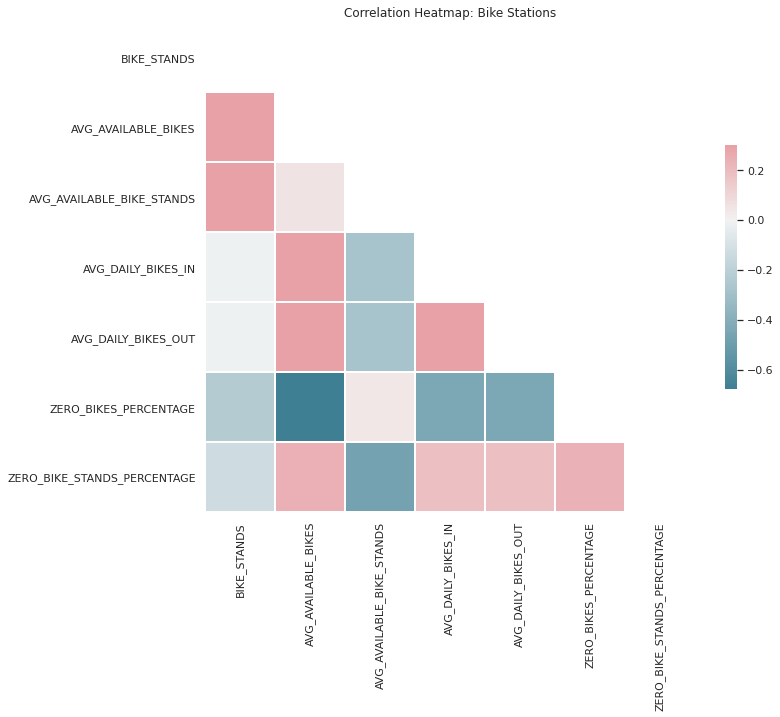

In [ ]:
import seaborn as sns
from string import ascii_letters

correlation_matrix = station_features_df[['BIKE_STANDS',	'AVG_AVAILABLE_BIKES', 'AVG_AVAILABLE_BIKE_STANDS',	
                                          'AVG_DAILY_BIKES_IN',	'AVG_DAILY_BIKES_OUT',
                                          'ZERO_BIKES_PERCENTAGE',	'ZERO_BIKE_STANDS_PERCENTAGE']].corr()


# ------------------------------------------------------------------------
sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)), columns=list(ascii_letters[26:]))

# Compute the correlation matrix
# ASSIGN THE "corr" VARIABLE TO YOUR CORRELATION MATRIX
corr = correlation_matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Bike Stations")
plt.show()

In [ ]:
station_features_df.describe()

,STATION_ID,LATITUDE,LONGITUDE,BIKE_STANDS,AVG_AVAILABLE_BIKES,AVG_AVAILABLE_BIKE_STANDS,AVG_DAILY_BIKES_IN,AVG_DAILY_BIKES_OUT,TOTAL_ROWS,NO._ROWS_WITH_ZERO_BIKES,ZERO_BIKES_PERCENTAGE,NO._ROWS_WITH_ZERO_BIKE_STANDS,ZERO_BIKE_STANDS_PERCENTAGE
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,57.633929,53.345225,-6.264094,31.955357,11.529377,20.039688,47.933326,47.953114,229927.008929,30635.776786,0.134890,10082.901786,0.046450
std,33.207238,0.007436,0.018347,7.549701,4.027805,6.312447,21.424451,21.408680,33493.017288,15365.493289,0.070626,9957.252686,0.054475
min,1.000000,53.330090,-6.310015,16.000000,3.133759,7.839898,9.581121,9.560472,50403.000000,3467.000000,0.015787,75.000000,0.000314
25%,29.750000,53.339930,-6.274056,29.000000,8.480197,14.436662,31.275382,31.348225,238673.750000,19839.000000,0.089954,3832.750000,0.016049
50%,57.500000,53.344228,-6.262741,30.000000,11.357393,19.634778,42.243772,42.172598,238769.000000,27569.500000,0.122474,6537.000000,0.028289
75%,85.250000,53.349152,-6.251393,40.000000,14.615104,24.938460,61.553084,61.695136,238799.250000,41136.000000,0.175223,14019.250000,0.063463
max,117.000000,53.359966,-6.230852,40.000000,22.414427,32.650055,103.176750,103.304864,238822.000000,68802.000000,0.499633,62051.000000,0.450608


In [ ]:
station_features_df[['STATION_ID','BIKE_STANDS','AVG_AVAILABLE_BIKES',	'AVG_DAILY_BIKES_OUT',	'ZERO_BIKES_PERCENTAGE','ZERO_BIKE_STANDS_PERCENTAGE']].describe()

,STATION_ID,BIKE_STANDS,AVG_AVAILABLE_BIKES,AVG_DAILY_BIKES_OUT,ZERO_BIKES_PERCENTAGE,ZERO_BIKE_STANDS_PERCENTAGE
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,57.633929,31.955357,11.529377,47.953114,0.134890,0.046450
std,33.207238,7.549701,4.027805,21.408680,0.070626,0.054475
min,1.000000,16.000000,3.133759,9.560472,0.015787,0.000314
25%,29.750000,29.000000,8.480197,31.348225,0.089954,0.016049
50%,57.500000,30.000000,11.357393,42.172598,0.122474,0.028289
75%,85.250000,40.000000,14.615104,61.695136,0.175223,0.063463
max,117.000000,40.000000,22.414427,103.304864,0.499633,0.450608


In [ ]:
# Crowded stations (lack of available bikes)
station_features_df[station_features_df['ZERO_BIKES_PERCENTAGE'] >= 0.25].sort_values('ZERO_BIKES_PERCENTAGE', ascending=False)

,STATION_ID,NAME,ADDRESS,LATITUDE,LONGITUDE,BIKE_STANDS,AVG_AVAILABLE_BIKES,AVG_AVAILABLE_BIKE_STANDS,AVG_DAILY_BIKES_IN,AVG_DAILY_BIKES_OUT,TOTAL_ROWS,NO._ROWS_WITH_ZERO_BIKES,ZERO_BIKES_PERCENTAGE,NO._ROWS_WITH_ZERO_BIKE_STANDS,ZERO_BIKE_STANDS_PERCENTAGE
33,35,SMITHFIELD,Smithfield,53.347690,-6.278214,30,5.923380,10.658974,40.791753,40.814433,137705,68802,0.499633,62051,0.450608
10,11,EARLSFORT TERRACE,Earlsfort Terrace,53.334020,-6.258371,30,6.421176,23.527527,31.737841,31.621590,238570,67231,0.281808,3356,0.014067
25,27,MOLESWORTH STREET,Molesworth Street,53.341290,-6.258117,20,7.431260,12.517283,45.217082,45.058126,238668,65596,0.274842,15222,0.063779
53,55,HATCH STREET,Hatch Street,53.334030,-6.260714,36,6.550352,29.067253,27.310795,27.196916,238591,65251,0.273485,2729,0.011438
28,30,PARNELL SQUARE NORTH,Parnell Square North,53.353462,-6.265305,20,3.133759,16.839638,23.303677,23.334520,238660,65182,0.273117,512,0.002145
14,15,HARDWICKE STREET,Hardwicke Street,53.355473,-6.264423,16,3.488709,12.494564,24.569395,24.669039,238772,62890,0.263389,1042,0.004364
96,98,FREDERICK STREET SOUTH,Frederick Street South,53.341515,-6.256853,40,11.678553,25.612134,25.115202,25.220903,238263,61887,0.259742,19718,0.082757
5,6,CHRISTCHURCH PLACE,Christchurch Place,53.343370,-6.270120,20,5.437884,14.505111,38.446026,38.376038,238700,60936,0.255283,6403,0.026824


In [ ]:
# Quiet stations (maybe too many available bikes)
station_features_df[station_features_df['ZERO_BIKES_PERCENTAGE'] < 0.03].sort_values('ZERO_BIKES_PERCENTAGE', ascending=False)

,STATION_ID,NAME,ADDRESS,LATITUDE,LONGITUDE,BIKE_STANDS,AVG_AVAILABLE_BIKES,AVG_AVAILABLE_BIKE_STANDS,AVG_DAILY_BIKES_IN,AVG_DAILY_BIKES_OUT,TOTAL_ROWS,NO._ROWS_WITH_ZERO_BIKES,ZERO_BIKES_PERCENTAGE,NO._ROWS_WITH_ZERO_BIKE_STANDS,ZERO_BIKE_STANDS_PERCENTAGE
62,64,SANDWITH STREET,Sandwith Street,53.345203,-6.247163,40,17.352921,22.581409,53.014235,52.984579,238801,6906,0.028919,4266,0.017864
65,67,THE POINT,The Point,53.346867,-6.230852,40,17.796681,22.128042,64.587189,64.529063,238812,4586,0.019203,3250,0.013609
89,91,SOUTH DOCK ROAD,South Dock Road,53.341830,-6.231291,30,16.715876,13.225216,67.275208,67.462633,238811,3770,0.015787,11488,0.048105


**Evaluation:**

The station "SMITHFIELD" (ID = 35) has a significant ZERO_BIKES_PERCENTAGE (49%). In my opinion, they should bring more bikes (get from quiet stations which have ZERO_BIKES_PERCENTAGE < 3%) to this station. And also consider redistributing the bike to the remainning list of crowded stations with ZERO_BIKES_PERCENTAGE >= 25%  

### 4.5.2. Clustering stations into 5 groups

Clustering into 5 levels of traffic (Very Low, Low, Medium, High, and Very High) based on 2 features of stations: BIKE_STANDS and AVG_DAILY_BIKES_OUT)

#### 4.5.2.1. Using K-Means

[1 2 2 2 3 2 4 1 1 2 4 2 4 1 2 2 2 1 1 4 2 1 1 4 2 2 1 1 2 1 1 1 1 4 0 4 3
 2 2 2 1 1 1 4 4 0 3 3 3 0 4 0 4 0 3 2 3 2 1 2 0 4 0 0 3 3 3 3 1 0 4 4 4 0
 0 4 0 4 0 0 2 0 4 4 0 0 4 0 0 1 0 0 0 0 4 0 0 4 1 4 0 0 0 0 4 0 0 1 0 0 4
 0]


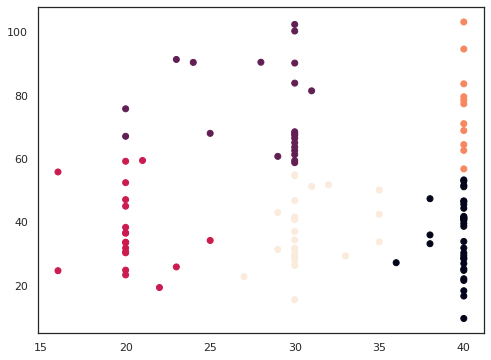

In [ ]:
# Convert station_features_df data to an Array for K-Means processing
# Initial a List
data = []
# Loop all rows of station_features_df and append these data to the List "data"
for i in station_features_df.index:
  data.append([station_features_df['BIKE_STANDS'][i],station_features_df['AVG_DAILY_BIKES_OUT'][i]])
# Conver a List to an Array
data = np.array(data)

# Import libraries for K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from numpy import float

# Initial K-Means model with 5 clustering (the model will cluster the input data into 5 groups)
model = KMeans(n_clusters=5)
# Scale the data to normalize it for good results
model = model.fit(scale(data))
# We can look at the clusters each data point was assigned to
print(model.labels_)

# And finally, we'll visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c=model.labels_.astype(float))
plt.show()

#### 4.5.2.2. Using Support Vector Machines

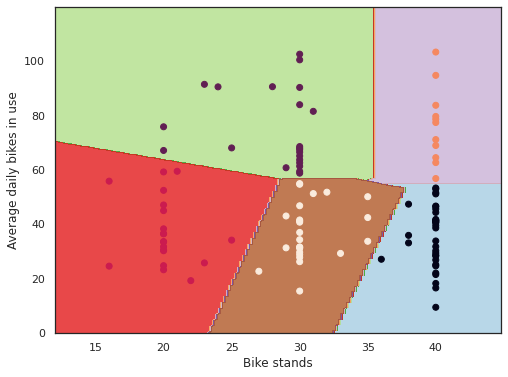

In [ ]:
# Interit the data and model of K-Means Clustering
X = data
y = model.labels_

# Import SVM library 
from sklearn import svm

# Initial linear SVC
C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit(X, y)

# Render the regions of each cluster as distinct colors
xx, yy = np.meshgrid(np.arange(12, 45, 0.2),np.arange(0, 120, 0.2))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
plt.figure(figsize=(8, 6))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
plt.xlabel('Bike stands')
plt.ylabel('Average daily bikes in use')
plt.show()